# Finite-Difference Simulation of Lid-Driven Cavity Flow
**(Final Assignment of Computational Physics 2025)**



## General Infromation about Running the Code 

1. In each cell, if there is a `#***` comment, code above it is meant to be adjusted frequently (like details for the plot) while code below it should not be changed.
2. If the package `numba` is not installed, you have two option: install it (recommended) *OR* change the `update_pressure()` function to the commented version which does not rely on numba but is really slow! You should then also comment the upper `update_pressure()` function to be save! The non-numba version already includes an attempt to improve (see docstring), but it did not do enough. Numba converts the code to non-python machine code to make it more efficient, since python is an efficiency-nightmare. And by this, I could use my original code for the pressure function.
3. To test the code, please reduce `grid_size` to around `(20,20)`, since the main simulation with the bigger grid size took me around two hours. You can also load the original data from the github repository!
4. Set `libertine_installed = True` only if you have this font installed. It matches my latex font but has to be installed first.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm # This will be used to get a better color scale for vorticity, since it has large boundary values
import os
from tqdm import tqdm
from numba import njit

print_titles = True # Set to True for show titles in figures for standalone use, False for the report
libertine_installed = True # Only set this to true if the font Linux Libertine is installed

# Create data and figures folders if they do not exist
folder = "data"
if not os.path.exists(folder):
    os.mkdir(folder)

folder = "figures"
if not os.path.exists(folder):
    os.mkdir(folder)
    

## Visualization

In [4]:
plt.rcParams.update({
    "axes.prop_cycle": plt.cycler(color=["black"] 
                            + plt.rcParams['axes.prop_cycle'].by_key()['color']),
    "font.family": "serif",             # Serif fonts (e.g., Times-like)
    "font.size": 14,                    # Base font size
    "mathtext.fontset": "cm",           # Math Font to match a bit better
    "legend.fontsize": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.dpi": 300,                  # High resolution
    "savefig.dpi": 300,
    "axes.linewidth": 0.8,              # Thin axis lines
    "xtick.direction": "in",            # Ticks pointing inward
    "ytick.direction": "in",
    "xtick.top": True,                  # Ticks on all sides
    "ytick.right": True,
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "grid.linewidth": 0.4
})

if libertine_installed: plt.rcParams.update({"font.serif": ["Linux Libertine"]})  # Same font as in LaTeX)

fsize_small = (4,2.75) # for a single colum in double colum
fsize_large = (6.5,4)

In [5]:
def plot_field(field, title, filename, fsize=fsize_small, show_contours=False, n_contours=3):
    """
    This is just for quick plotting, the actual figure are stand alone code below.
    INPUT
    -----
    field:    NxN numpy array to visualize
    title:    plot title
    filename: file where the figure will be saved, preferably as .pdf
    """

    plt.figure(figsize=fsize)
    im = plt.imshow(field, origin='lower', extent=[0,1,0,1], cmap='plasma')
    plt.colorbar(im, label='value (a.u.)')
    # Contours
    if show_contours:
        cs = plt.contour(
            field,
            levels=n_contours,
            colors="black",
            linewidths=0.8,
            origin='lower',
            extent=[0,1,0,1]
        )
    # plt.clabel(cs, inline=True, fontsize=8)

    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect('equal')
    plt.tight_layout()
    
    file = os.path.join("figures", filename)
    plt.savefig(file)
    plt.show()
    plt.close() 

## Building the LDC Simulation Class

In [38]:
class LDC:
    def __init__(self,h,dt,Re,grid_size, vx_top=1, vx_bottom=0):
        self.h = h
        self.dt = dt 
        self.Re = Re
        self.grid_size = grid_size
        self.vx_top = vx_top
        self.vx_bottom = vx_bottom
        self.initialize()

    # =====
    def initialize(self): # Careful, for changing grid_size you have to reassign the whole class`
        self.N_y, self.N_x = self.grid_size # first y then x, so if we print it out it corresponds to the figure

    def update_stream_SOR(self, u, w, omega, max_iter, tol):
        '''
        '''
        for it in range(max_iter):
            max_r = 0.0
            for j in range(1, self.N_y-1):
                for i in range(1, self.N_x-1):
                    u_new = 0.25 * (u[j+1,i] + u[j-1,i] + u[j,i+1] + u[j,i-1] + self.h*self.h * w[j,i])
                    r = u_new - u[j,i]
                    u[j,i] += omega * r
                    max_r = max(max_r, abs(r))

            if max_r < tol: break

        return u
    
    # =====
    def update_vorticity(self, w, u):
        ''' 
        See report for equation
        '''
        w_new = np.copy(w)

        termA = (u[1:-1, 2:] - u[1:-1, :-2]) * (w[2:, 1:-1] - w[:-2, 1:-1])
        termB= (u[2:, 1:-1] - u[:-2, 1:-1]) * (w[1:-1, 2:] - w[1:-1, :-2])
        termC = w[1:-1, 2:] + w[1:-1, :-2] + w[2:, 1:-1] + w[:-2, 1:-1] - 4 * w[1:-1, 1:-1]

        w_new[1:-1, 1:-1] = (w[1:-1, 1:-1] + self.dt / (self.h * self.h) * (0.25 * (termA - termB) + (1 / self.Re) * termC))

        return w_new
    
    #=====
    @staticmethod
    @njit
    def update_pressure_SOR(p, u, h, omega, max_iter, tol):
        ''' 
        IMPORTANT: this uses numba's njit for speed-up, which translates the code to non-Python code. This is WAYYY more efficient since 
        python kinda sucks for loops. (I also tried to vectorize it but it was still too slow since termA cannot be vectorized in SOR.)
        HOWEVER, numba cannot take class variables, so we have to take it out of the class by staticmethod and pass h as argument.
        We are also using red-black SOR which also improves performance and ram usage apparently (source: some guy on stackoverflow).

        I also tried a version with vectorized termB and termC, but it did not change much when using numba.
        '''
        N_y, N_x = p.shape
        factorC = 1/(16*h**2)
        for it in range(max_iter):
            max_r = 0.0

            for color in [0, 1]:  # Red-black SOR
                for j in range(1, N_y-1):
                    for i in range((j+color) % 2 +1, N_x-1, 2): # This selects every second grid point, shifted depending on color value
                        termA = (p[j,i+1] + p[j,i-1] + p[j+1,i] + p[j-1,i])
                        termB = 2 * (u[j,i+1] - 2 * u[j,i] + u[j,i-1]) * (u[j+1,i] - 2 * u[j,i] + u[j-1,i]) / (h*h)
                        termC = factorC * (u[j+1,i+1] - u[j-1,i+1] - u[j+1,i-1] + u[j-1,i-1])**2
                        p_new = (0.25) * (termA - termB - termC)

                        r = p_new - p[j,i]
                        p[j,i] += omega * r
                        max_r = max(max_r, abs(r))

            if max_r < tol: break

        return p

# =====   
# Only uncomment this if you do not want to use numba! To be sure then comment the other function above!

    # def update_pressure_SOR(self, p, u, h, omega, max_iter, tol):
    #     '''
    #     Note: this is an updated version with vectorized termB and termC for better performance. It was created with help 
    #     of AI and then checked by me! I then also compared the results to my old function and they are identical.
    #     The calculation of termB and termC can be changed to numpy vectorized operations, 
    #     while termA remains as is because it depends on p which is updated in each iteration.
    #     '''

    #     for it in range(max_iter):
    #         max_r = 0.0

    #         # termB = 2*(u[j,i+1] + u[j,i-1] + u[j+1,i] + u[j-1,i] - 4*u[j,i])
    #         termB = 2 * (
    #                 u[1:self.N_y-1, 2:self.N_x] +       # u[j,i+1]
    #                 u[1:self.N_y-1, 0:self.N_x-2] +     # u[j,i-1]
    #                 u[2:self.N_y,   1:self.N_x-1] +     # u[j+1,i]
    #                 u[0:self.N_y-2, 1:self.N_x-1] -     # u[j-1,i]
    #                 4*u[1:self.N_y-1, 1:self.N_x-1]
    #                 )

    #         # termC = 1/(8*h^2) * (u[j+1,i+1] - u[j-1,i+1] - u[j+1,i-1] + u[j-1,i-1])**2
    #         du = (
    #             u[2:self.N_y, 2:self.N_x]   # u[j+1,i+1]
    #             - u[0:self.N_y-2, 2:self.N_x]   # - u[j-1,i+1]
    #             - u[2:self.N_y, 0:self.N_x-2]    # - u[j+1,i-1]
    #             + u[0:self.N_y-2, 0:self.N_x-2]  # + u[j-1,i-1]
    #         )
    #         termC = (1.0 / (8 * h**2)) * (du * du)

    #         # Keep SOR update unchanged
    #         for j in range(1, self.N_y-1):
    #             for i in range(1, self.N_x-1):

    #                 termA = (p[j, i+1] + p[j, i-1] + p[j+1, i] + p[j-1, i])

    #                 # pull vectorized values
    #                 termB_ = termB[j-1, i-1]
    #                 termC_ = termC[j-1, i-1]

    #                 p_new = 0.25 * (termA - termB_ - termC_)

    #                 r = p_new - p[j, i]
    #                 p[j, i] += omega * r
    #                 max_r = max(max_r, abs(r))

    #         if max_r < tol:
    #             break

    #     return p
    
    # =====
    def vorticity_boundary(self, w, u):
        factor = 2/(self.h*self.h)
        w[-1, :] = - factor * u[-2,:] - (2/self.h) * self.vx_top    # Top wall (A)
        w[:, -1] = - factor * u[:,-2]                               # Right wall (B)
        w[0, :] = - factor * u[1, :] + (2/self.h) * self.vx_bottom  # Bottom wall (C)
        w[:, 0] = - factor * u[:, 1]                                # Left wall (D)

        return w
    
    # =====
    def pressure_boundary(self, p, w):
        ''' 
        
        '''  
        # (A) top wall
        for i in range(self.N_x-2):
            p[-1,i+1] = p[-1,i] - 1/self.Re * (w[-1,i] - w[-2,i])
        # (B) right wall
        for j in range(self.N_y-2):
            p[j+1,-1] = p[j,-1] + 1/self.Re * (w[j,-1] - w[j,-2])
        # (C) bottom wall
        for i in range(self.N_x-2):
            p[0,i+1] = p[0,i] - 1/self.Re * (w[1,i] - w[0,i])
            # (D) left wall
        for j in range(self.N_y-2):
            p[j+1,0] = p[j,0] + 1/self.Re * (w[j,1] - w[j,0])
            
        return p
    

    # =====
    def test_stability(self):
        stability = self.dt/(self.Re*self.h*self.h)
        if stability > 0.25:
            print(f'Warning: Stability condition not met! value: {stability:.3f}')
        else:
            print(f'Stability criterion value: {stability:.3f}')

        return None
    
    # =====       
    def get_vx_center(self, u):
        i = int(self.N_x/2)
        j = int(self.N_y/2)
        return (u[j,i+1] - u[j,i-1])/(2*self.h) 
    
    # =====
    def system_evolution(self, 
                    n_t,
                    get_pressure=True,
                    SOR_omega=1.9,  
                    SOR_max_iter=1000, 
                    SOR_tol=1e-5,
                    ):
        '''
        '''
        self.test_stability()

        # Initialize storage arrays and arrays at t=0
        u = np.zeros((self.N_y, self.N_x)) # u at t=0 is 0
        w = np.zeros((self.N_y, self.N_x))
        w[-1, :] = -2 * self.vx_top / self.h  # Top wall vorticity at t=0 (u=0 everywhere)
        w[0, :] = 2 * self.vx_bottom / self.h  # Bottom wall vorticity at t=0 
        vxc_history = np.zeros(n_t)

        p = np.zeros((self.N_y, self.N_x))  # Initialize pressure array

        for n in tqdm(range(1,n_t)):
            # Update stream function
            u = self.update_stream_SOR(u, w, omega=SOR_omega, max_iter=SOR_max_iter, tol=SOR_tol)
            w = self.vorticity_boundary(w, u)
            w = self.update_vorticity(w, u)
            
            vxc_history[n] = self.get_vx_center(u)

            if get_pressure:
                p = self.pressure_boundary(p, w)
                p = self.update_pressure_SOR(p, u, self.h, omega=SOR_omega, max_iter=SOR_max_iter, tol=SOR_tol)

        if get_pressure:
            return u, w, p, vxc_history
        else:
            return u, w, vxc_history
       

Then for the evaluation, let's add a function to create the velocities from the stream function:

In [2]:
def get_velocities(u, h):
    '''
    '''

    vx = np.zeros_like(u)
    vy = np.zeros_like(u)

    vx[1:-1, :] = (u[2:,:] - u[:-2,:]) / (2*h) # Central differences
    vy[:,1:-1] = - (u[:,2:] - u[:,:-2]) / (2*h) # Central differences

    # Boundaries
    vx[-1,:] = (u[-1,:] - u[-2,:]) / h  # Top wall need backwards difference
    vx[0,:] = (u[1,:] - u[0,:]) / h     # Bottom wall need forwards difference
    vy[:,0] = - (u[:,1] - u[:,0]) / h   # Left wall need forwards difference
    vy[:,-1] = - (u[:,-1] - u[:,-2]) / h # Right wall need backwards difference

    # For the plot, we will also return the mashgrid straight away
    N_y, N_x = u.shape
    x = np.linspace(0, 1, N_x)
    y = np.linspace(0, 1, N_y)
    X, Y = np.meshgrid(x, y)

    return vx, vy, X, Y

Let's test the function for a small grid size and a low number of time steps:

Stability criterion value: 0.200


100%|██████████| 99/99 [00:03<00:00, 31.08it/s]


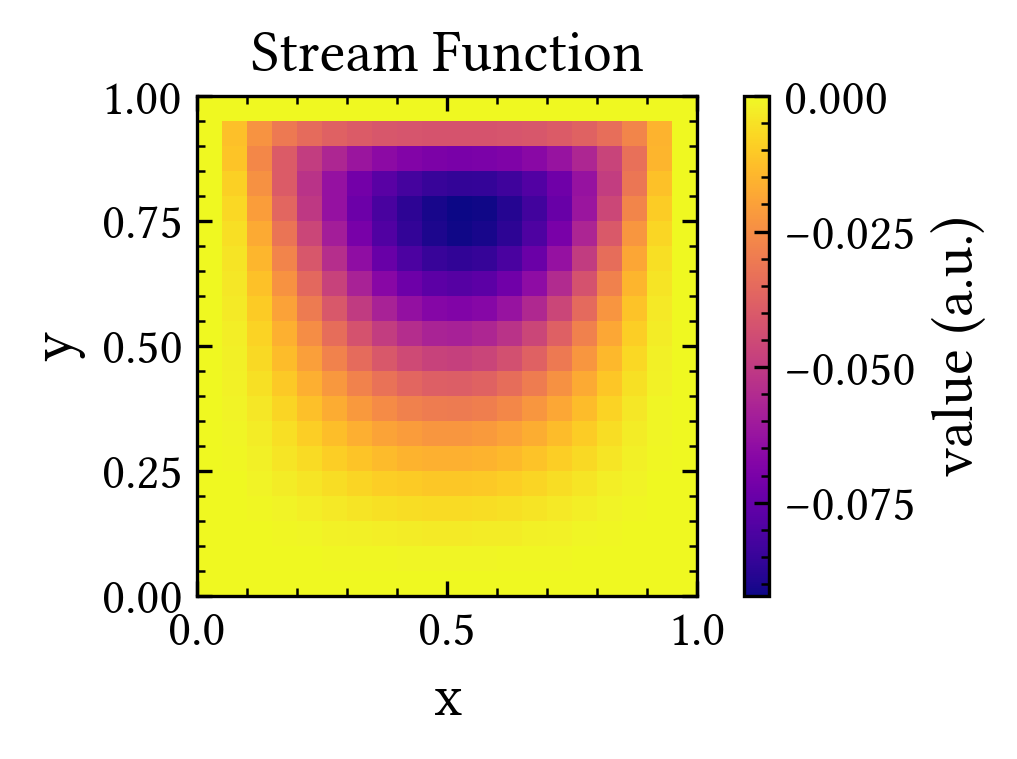

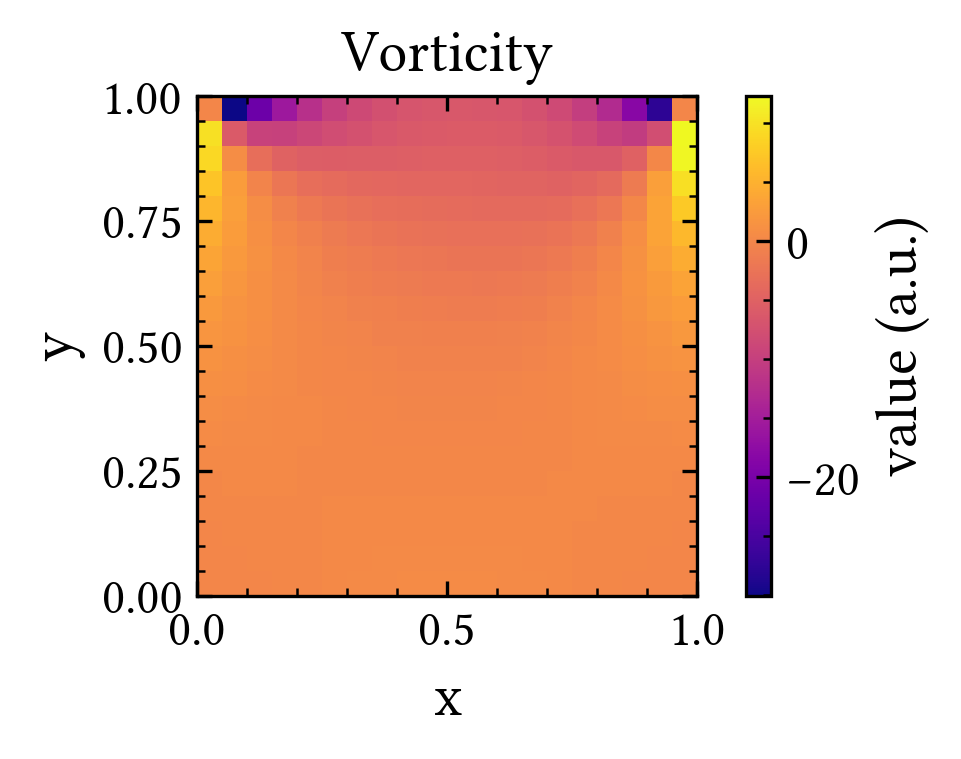

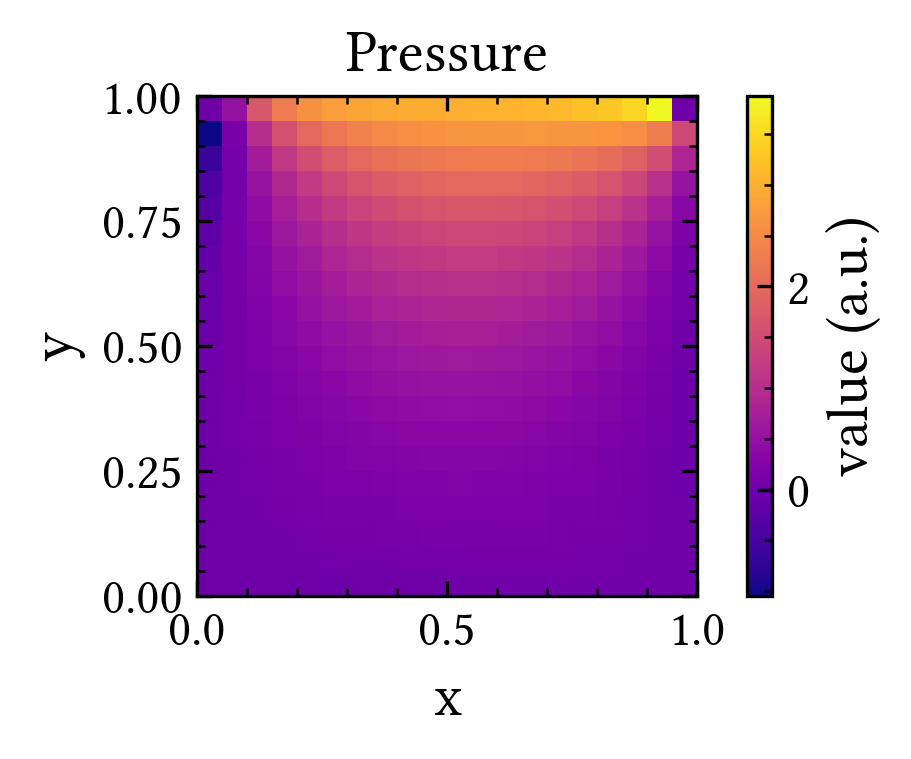

In [7]:
ldc_test = LDC(h=(1/20), dt=0.01, Re=20, grid_size=(20,20))
u_test, w_test, p_test, _ = ldc_test.system_evolution(n_t=100,get_pressure=True)

plot_field(u_test, title="Stream Function", filename="stream_function_test.pdf")
plot_field(w_test, title="Vorticity", filename="vorticity_test.pdf")
plot_field(p_test, title="Pressure", filename="pressure_test.pdf")    

## **A** Only Top Wall is Movng

If the simulation has already been run, skip this cell and just load the data from the cell below.

In [ ]:
save_data = False
T = 25 # Fix the total amount of time for Re=100 and Re=200
grid_size = (100,100)
SOR_tol = 1e-4

# *********
h = 1/grid_size[0] # Since side length is 1
dt_10 = 0.1*h*h*10 # Stability condition, to be on the safe side we take 0.1 instead of 0.25
nt_10 = int(5/dt_10) # For Re=10, the steady state comes quicker (determined with coarse first run)

dt_100 = 0.1*h*h*100 
nt_100 = int(T/dt_100)

dt_200 = 0.1*h*h*200 
nt_200 = int(T/dt_200)

print(f"Re=10, dt={dt_10:.3e}, nt={nt_10}")
ldc_10 = LDC(h=h,
             dt = dt_10,
             Re = 10,
             grid_size=grid_size,
             )

u_10, w_10, p_10, vxc_10 = ldc_10.system_evolution(n_t=nt_10, get_pressure=True, SOR_tol=SOR_tol)

# Save the data as dictionary so to not run the simulation again
if save_data:
    ldc_Re10 = {'u': u_10, 'w': w_10, 'vxc': vxc_10, 'p': p_10, 'params': (h, dt_10, nt_10)}
    np.save('data/ldc_Re10.npy', ldc_Re10)

print(f"Re=100, dt={dt_100:.3e}, nt={nt_100}")
ldc_100 = LDC(h=h,
             dt = dt_100,
             Re = 100,
             grid_size=grid_size,
             )

u_100, w_100, p_100, vxc_100 = ldc_100.system_evolution(n_t=nt_100, get_pressure=True, SOR_tol=SOR_tol)

if save_data:
    ldc_Re100 = {'u': u_100, 'w': w_100, 'vxc': vxc_100, 'p': p_100, 'params': (h, dt_100, nt_100)}
    np.save('data/ldc_Re100.npy', ldc_Re100)

print(f"Re=200, dt={dt_200:.3e}, nt={nt_200}")
ldc_200 = LDC(h = h,
             dt = dt_200,
             Re = 200,
             grid_size=grid_size,
             )

u_200, w_200, p_200, vxc_200  = ldc_200.system_evolution(n_t=nt_200, get_pressure=True, SOR_tol=SOR_tol)

if save_data:
    ldc_Re200 = {'u': u_200, 'w': w_200, 'vxc': vxc_200, 'p': p_200, 'params': (h, dt_200, nt_200)}
    np.save('data/ldc_Re200.npy', ldc_Re200)

The cell below is to load the data directly instead of simulating it, if the simulation cell above was run before.

In [8]:
ldc_Re10 = np.load('data/ldc_Re10.npy', allow_pickle=True).item()
u_10 = ldc_Re10['u']
w_10 = ldc_Re10['w']
vxc_10 = ldc_Re10['vxc']
p_10 = ldc_Re10['p']
h, dt_10, nt_10 = ldc_Re10['params']

ldc_Re100 = np.load('data/ldc_Re100.npy', allow_pickle=True).item()
u_100 = ldc_Re100['u']
w_100 = ldc_Re100['w']
vxc_100 = ldc_Re100['vxc']
p_100 = ldc_Re100['p']
_, dt_100, nt_100 = ldc_Re100['params']

ldc_Re200 = np.load('data/ldc_Re200.npy', allow_pickle=True).item()
u_200 = ldc_Re200['u'] 
w_200 = ldc_Re200['w']
vxc_200 = ldc_Re200['vxc']
p_200 = ldc_Re200['p']
_, dt_200, nt_200 = ldc_Re200['params']

Plotting the Results:

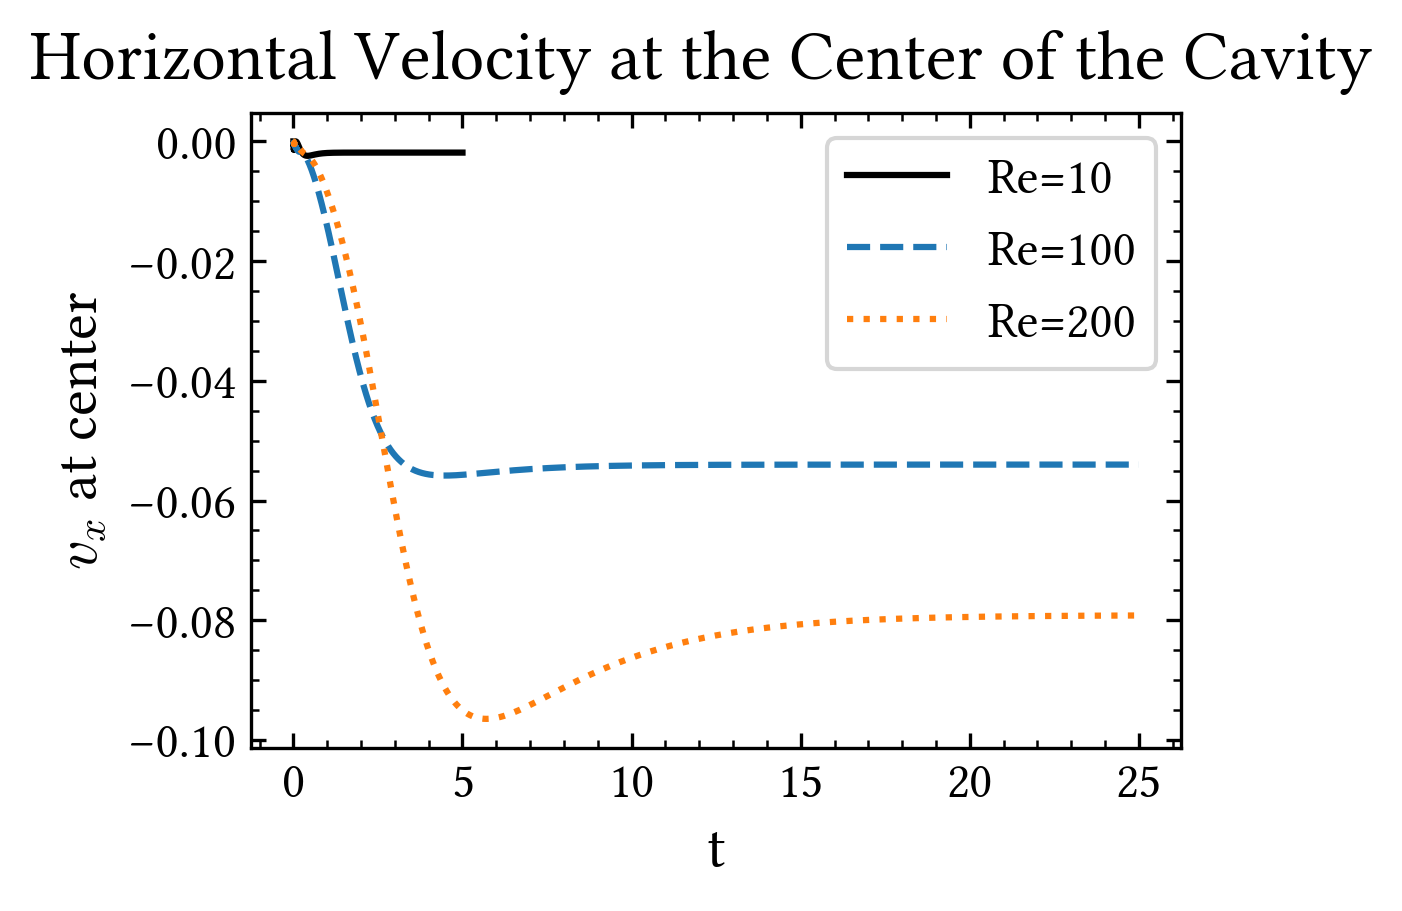

In [33]:
t_10 = np.arange(nt_10)*dt_10
t_100 = np.arange(nt_100)*dt_100
t_200 = np.arange(nt_200)*dt_200

fig, ax = plt.subplots(figsize=fsize_small)
if print_titles: fig.suptitle("Horizontal Velocity at the Center of the Cavity")

ax.plot(t_10[1:], vxc_10[1:], label='Re=10')
ax.plot(t_100[1:], vxc_100[1:], label='Re=100', linestyle='--')
ax.plot(t_200[1:], vxc_200[1:], label='Re=200', linestyle=':')

ax.set_xlabel(r"t")
ax.set_ylabel(r"$v_x$ at center")
ax.legend()

plt.savefig('figures/vx_center.pdf')
plt.show()

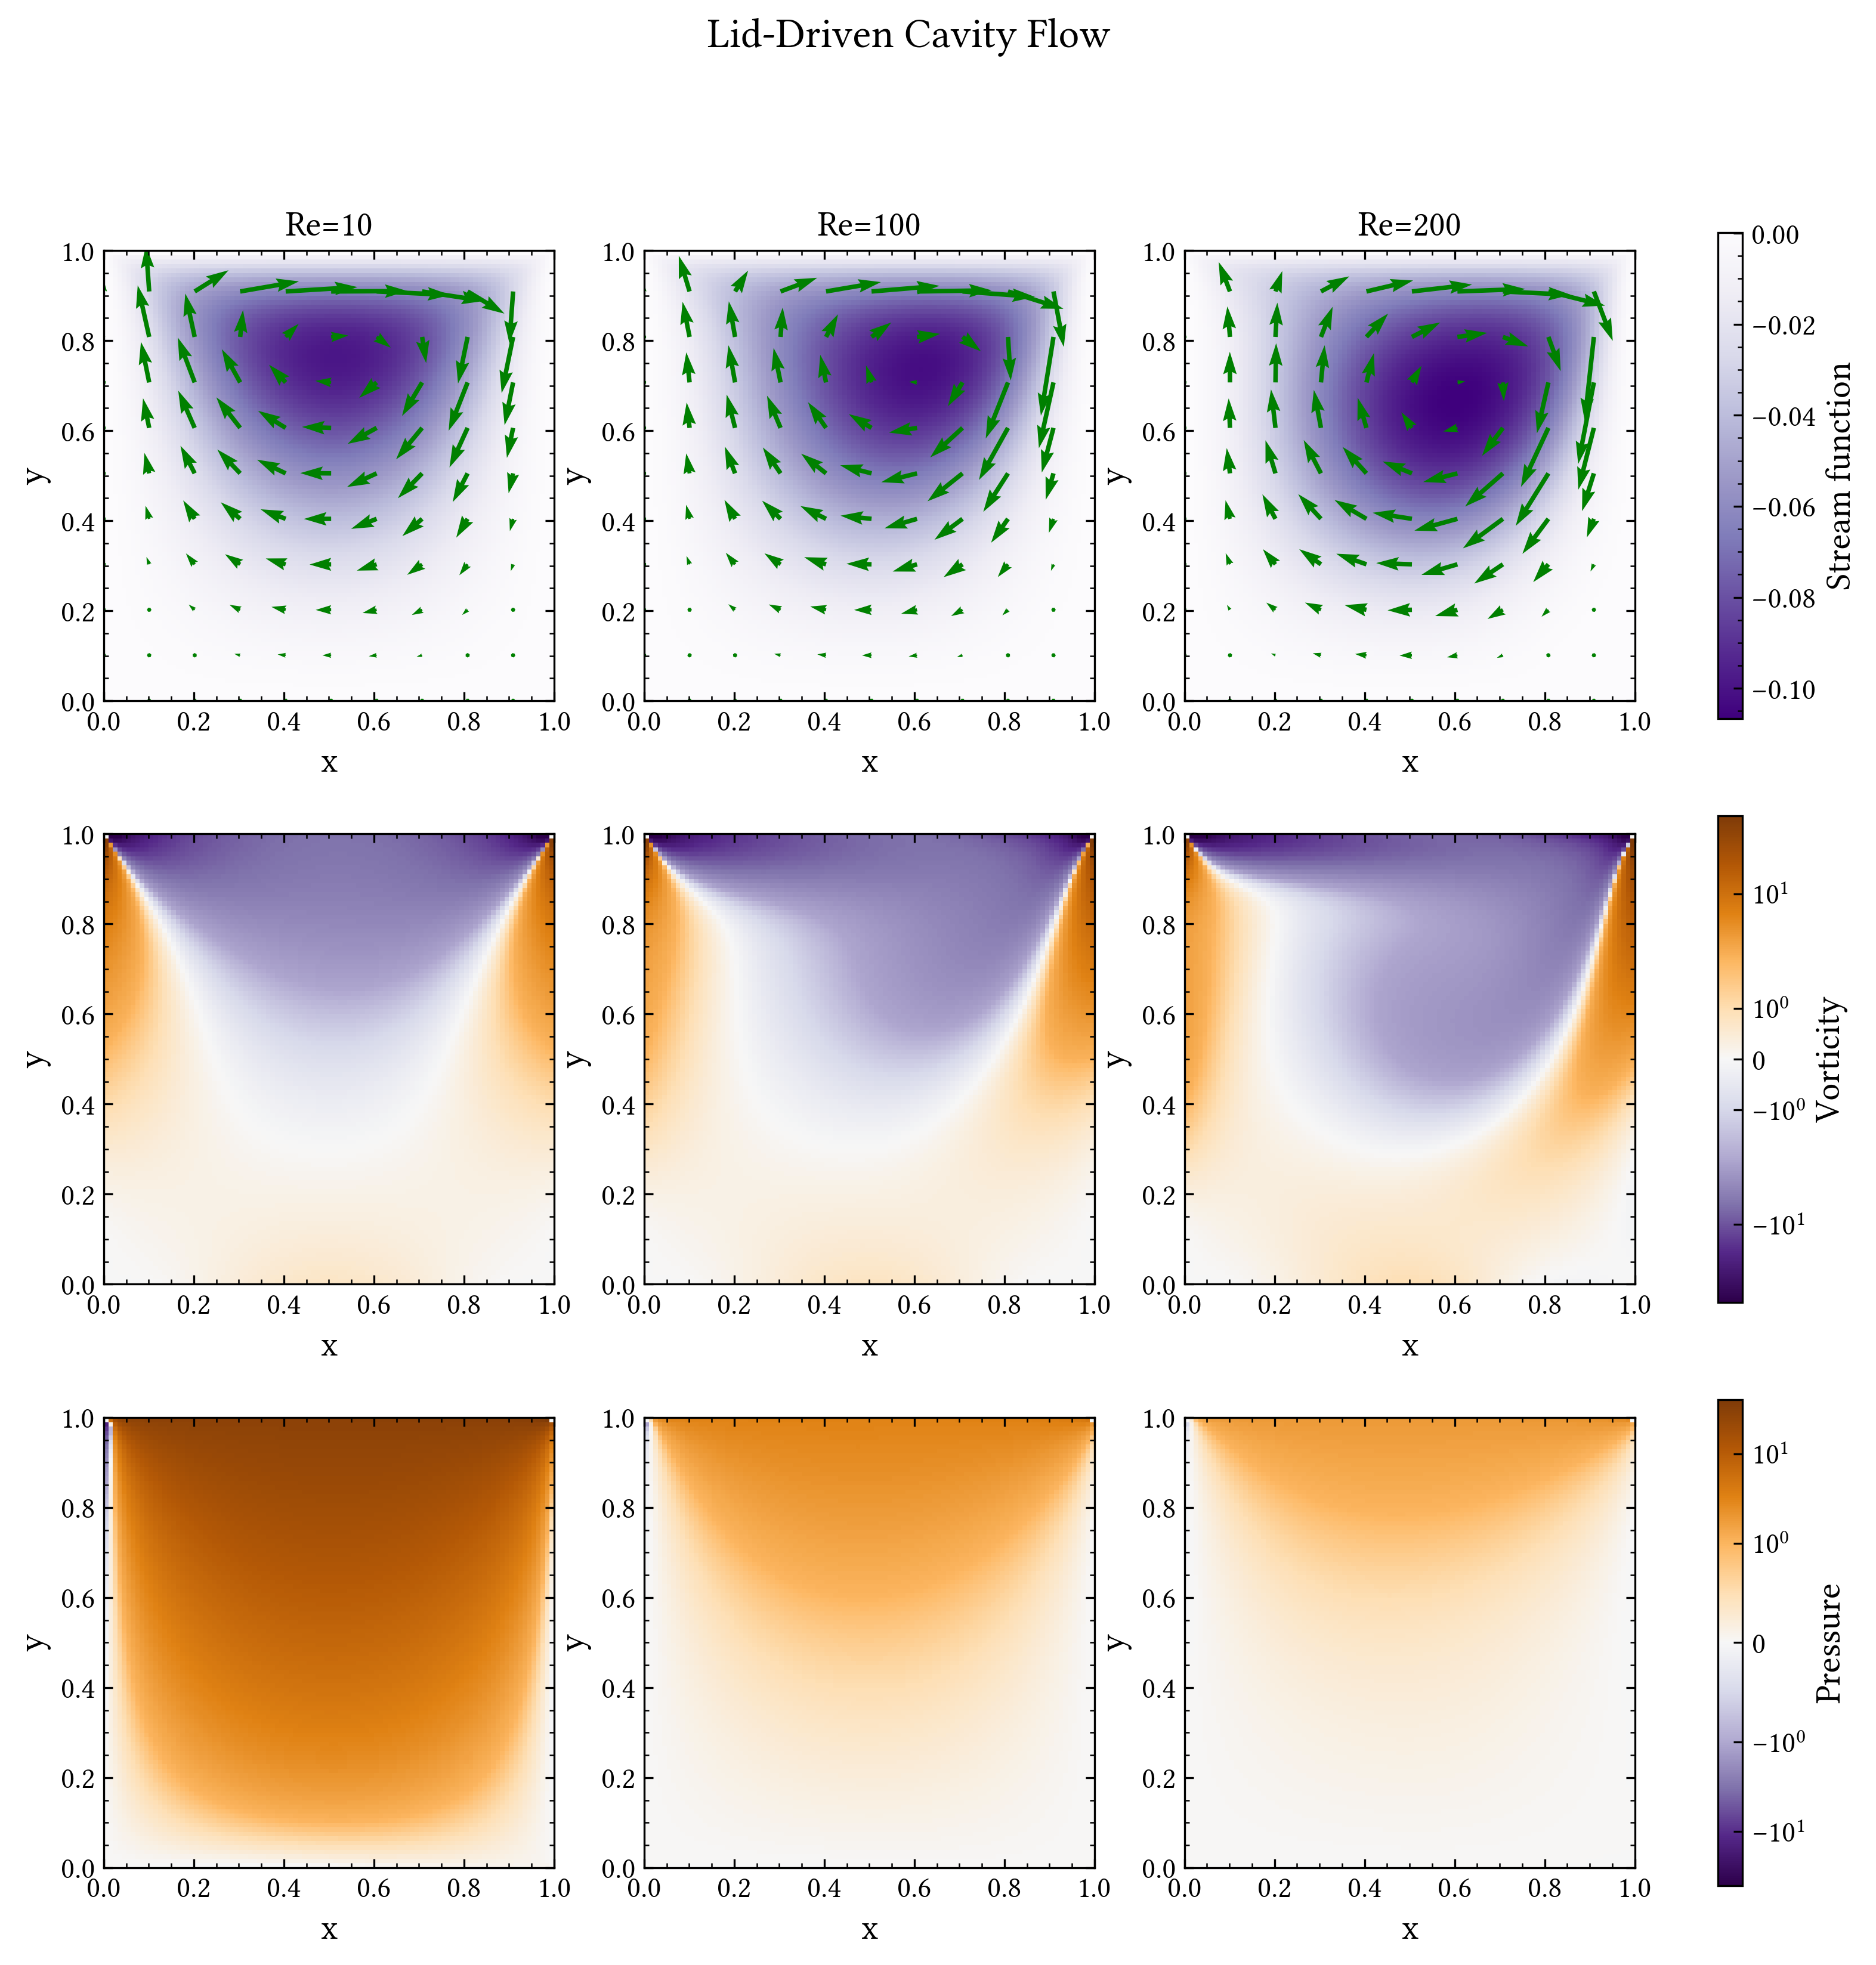

In [34]:
n_vectors = 10 # Number of velocity arrows per row

# ********
# To get a shared color scale, we need to find the min/max values for each row
u_vals = np.concatenate((u_10.ravel(), u_100.ravel(), u_200.ravel())) # np.ravel makes an array 1D
w_vals   = np.concatenate((w_10.ravel(), w_100.ravel(), w_200.ravel()))
p_vals   = np.concatenate((p_10.ravel(), p_100.ravel(), p_200.ravel()))

u_min, u_max = u_vals.min(), u_vals.max()
w_abs = np.abs(w_vals.max()) # The voricity and pressure color scale will be centered around zero 
p_abs = np.abs(p_vals.max())
# w_min,   w_max   = w_vals.min(),   w_vals.max()
# p_min,   p_max   = p_vals.min(),   p_vals.max()

vx_10, vy_10, X, Y = get_velocities(u_10, h)
vx_100, vy_100, _, _ = get_velocities(u_100, h)
vx_200, vy_200, _, _ = get_velocities(u_200, h)
step = int(vx_10.shape[0] / n_vectors)

vx_dict = {10: vx_10, 100: vx_100, 200: vx_200}
vy_dict = {10: vy_10, 100: vy_100, 200: vy_200}


fig, axes = plt.subplots(3, 3, figsize=(12,12))
if print_titles: fig.suptitle("Lid-Driven Cavity Flow")

# To have less code, we will plot inside a loop through the Re values
Re_list = [10, 100, 200]
u_dict = {10: u_10, 100: u_100, 200: u_200}
w_dict = {10: w_10, 100: w_100, 200: w_200}
p_dict = {10: p_10, 100: p_100, 200: p_200}


for col, Re in enumerate(Re_list):

    # Stream function row
    ax = axes[0, col]
    im0 = ax.imshow(u_dict[Re], origin='lower', extent=[0,1,0,1],
                    cmap='Purples_r', vmin=u_min, vmax=u_max) # Reversing the colormap so 0 is white
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")
    ax.set_title(f"Re={Re}")

    # Add velocity vectors
    ax.quiver(X[::step, ::step], Y[::step, ::step],
              vx_dict[Re][::step, ::step], vy_dict[Re][::step, ::step], 
              scale=3, width=0.01, color='green')

    # Vorticity row
    ax = axes[1, col]
    # Reversing the colormap because lets be hones, blue feels more like negative. Also using SymLogNorm for better color scale
    im1 = ax.imshow(w_dict[Re], origin='lower', extent=[0,1,0,1],
                    cmap='PuOr_r', norm=SymLogNorm(linthresh=2, linscale=1.0, vmin=-w_abs, vmax=w_abs)) 
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")

    # Pressure row
    ax = axes[2, col]
    im2 = ax.imshow(p_dict[Re], origin='lower', extent=[0,1,0,1],
                    cmap='PuOr_r', norm=SymLogNorm(linthresh=1, linscale=1.0, vmin=-p_abs, vmax=p_abs))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")

# Colorbars for each row, with the same color scale
cbar0 = fig.colorbar(im0, ax=axes[0, :], orientation='vertical', fraction=0.03)
cbar0.set_label("Stream function")

cbar1 = fig.colorbar(im1, ax=axes[1, :], orientation='vertical', fraction=0.03)
cbar1.set_label("Vorticity")

cbar2 = fig.colorbar(im2, ax=axes[2, :], orientation='vertical', fraction=0.03)
cbar2.set_label("Pressure")

plt.savefig('figures/fields_comparison.pdf')
plt.show()


## **B** Moving Bottom Wall in Positive Direction (BWP)

This is basically copy pasting the code and then changing every variable name, so there is no mix up even if you rerun cells from above.

In [39]:
save_data = False

T = 25 # Fix the total amount of time for Re=100 and Re=200. Re=10 is quickly in steady state.
grid_size = (40,40)
h = 1/grid_size[0] # Since side length is 1

SOR_tol = 1e-4
dt_10 = 0.1*h*h*10 # Stability condition, to be on the safe side we take 0.1 instead of 0.25
nt_10 = int(5/dt_10) # We take only 5 seconds here 

dt_100 = 0.1*h*h*100 
nt_100 = int(T/dt_100)

dt_200 = 0.1*h*h*200 
nt_200 = int(T/dt_200)

print(f"Re=10, dt={dt_10:.3e}, nt={nt_10}")
# bwp = positive moving bottom wall
ldc_bwp_10 = LDC(h=h,
             dt = dt_10,
             Re = 10,
             grid_size=grid_size,
             vx_bottom=1 # Moving bottom wall
             )

u_bwp_10, w_bwp_10, p_bwp_10, vxc_bwp_10 = ldc_bwp_10.system_evolution(n_t=nt_10, get_pressure=True, SOR_tol=SOR_tol)

# Save the data as dictionary so to not run the simulation again
if save_data:
    ldc_bwp_10 = {'u': u_bwp_10, 'w': w_bwp_10, 'vxc': vxc_bwp_10, 'p': p_bwp_10, 'params': (h, dt_10, nt_10)}
    np.save('data/ldc_bwp_10.npy', ldc_bwp_10)

print(f"Re=100, dt={dt_100:.3e}, nt={nt_100}")
ldc_bwp_100 = LDC(h=h,
             dt = dt_100,
             Re = 100,
             grid_size=grid_size,
             vx_bottom=1 
             )

u_bwp_100, w_bwp_100, p_bwp_100, vxc_bwp_100 = ldc_bwp_100.system_evolution(n_t=nt_100, get_pressure=True, SOR_tol=SOR_tol)

if save_data:
    ldc_bwp_100 = {'u': u_bwp_100, 'w': w_bwp_100, 'vxc': vxc_bwp_100, 'p': p_bwp_100, 'params': (h, dt_100, nt_100)}
    np.save('data/ldc_bwp_100.npy', ldc_bwp_100)

print(f"Re=200, dt={dt_200:.3e}, nt={nt_200}")
ldc_bwp_200 = LDC(h = h,
             dt = dt_200,
             Re = 200,
             grid_size=grid_size,
             vx_bottom=1
             )

u_bwp_200, w_bwp_200, p_bwp_200, vxc_bwp_200  = ldc_bwp_200.system_evolution(n_t=nt_200, get_pressure=True, SOR_tol=SOR_tol)

if save_data:
    ldc_bwp_200 = {'u': u_bwp_200, 'w': w_bwp_200, 'vxc': vxc_bwp_200, 'p': p_bwp_200, 'params': (h, dt_200, nt_200)}
    np.save('data/ldc_bwp_200.npy', ldc_bwp_200)

Re=10, dt=6.250e-04, nt=7999
Stability criterion value: 0.100


100%|██████████| 7998/7998 [00:21<00:00, 373.39it/s]


Re=100, dt=6.250e-03, nt=3999
Stability criterion value: 0.100


100%|██████████| 3998/3998 [00:11<00:00, 361.53it/s]


Re=200, dt=1.250e-02, nt=1999
Stability criterion value: 0.100


100%|██████████| 1998/1998 [00:06<00:00, 305.48it/s]


Or again, load the data directly:

In [22]:
ldc_bwp_10 = np.load('data/ldc_bwp_10.npy', allow_pickle=True).item()
u_bwp_10 = ldc_bwp_10['u']
w_bwp_10 = ldc_bwp_10['w']
vxc_bwp_10 = ldc_bwp_10['vxc']
p_bwp_10 = ldc_bwp_10['p']
h, dt_10, nt_10 = ldc_bwp_10['params']

ldc_bwp_100 = np.load('data/ldc_bwp_100.npy', allow_pickle=True).item()
u_bwp_100 = ldc_bwp_100['u']
w_bwp_100 = ldc_bwp_100['w']
vxc_bwp_100 = ldc_bwp_100['vxc'] 
p_bwp_100 = ldc_bwp_100['p']
_, dt_100, nt_100 = ldc_bwp_100['params']

ldc_bwp_200 = np.load('data/ldc_bwp_200.npy', allow_pickle=True).item()
u_bwp_200 = ldc_bwp_200['u'] 
w_bwp_200 = ldc_bwp_200['w']
vxc_bwp_200 = ldc_bwp_200['vxc']
p_bwp_200 = ldc_bwp_200['p']
_, dt_200, nt_200 = ldc_bwp_200['params']

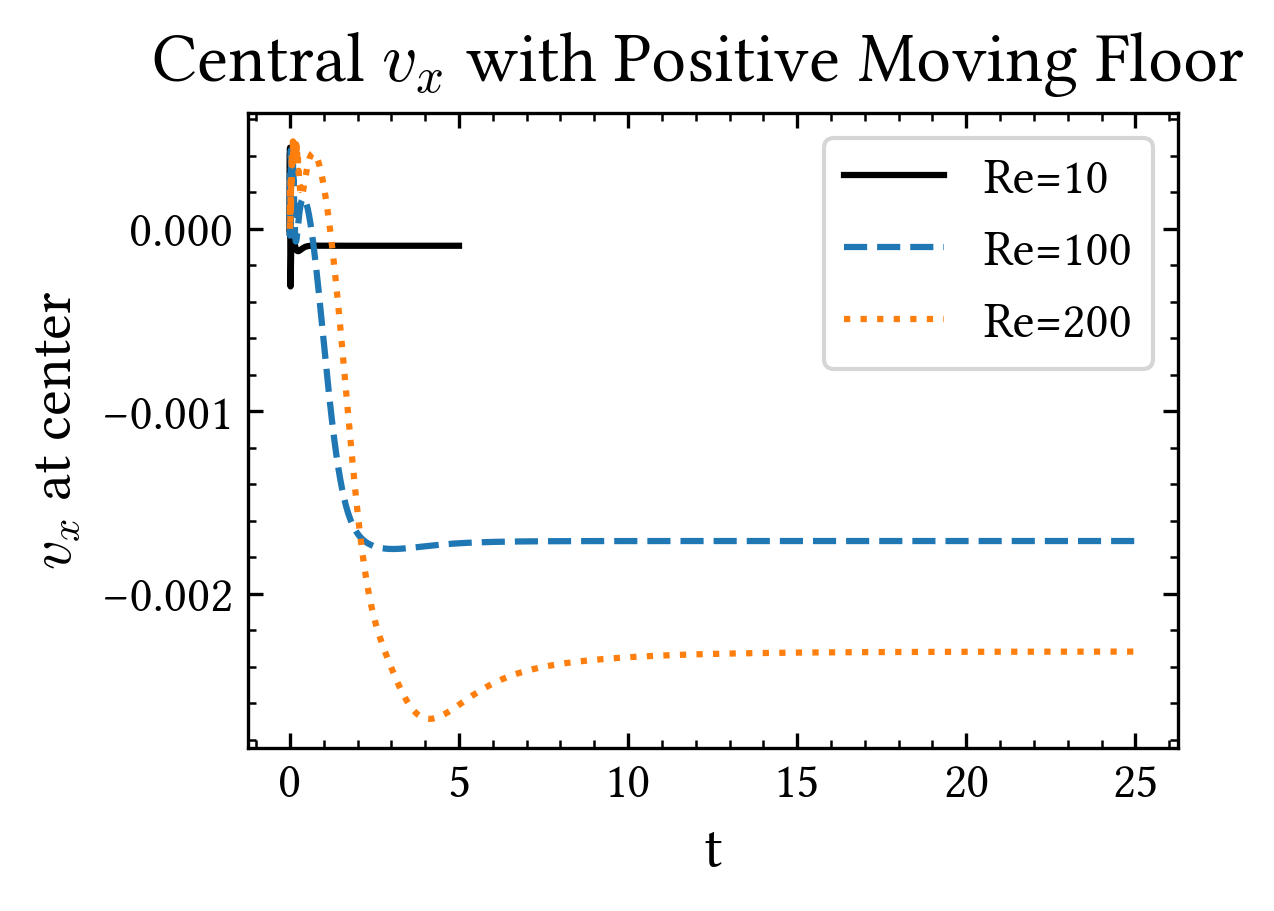

In [36]:
t_10 = np.arange(nt_10)*dt_10
t_100 = np.arange(nt_100)*dt_100
t_200 = np.arange(nt_200)*dt_200

fig, ax = plt.subplots(figsize=fsize_small)
if print_titles: fig.suptitle(r"Central $v_x$ with Positive Moving Floor")

ax.plot(t_10[1:], vxc_bwp_10[1:], label='Re=10')
ax.plot(t_100[1:], vxc_bwp_100[1:], label='Re=100', linestyle='--')
ax.plot(t_200[1:], vxc_bwp_200[1:], label='Re=200', linestyle=':')

ax.set_xlabel(r"t")
ax.set_ylabel(r"$v_x$ at center")
ax.legend()

plt.savefig('figures/vxc_bwp.pdf')
plt.show()

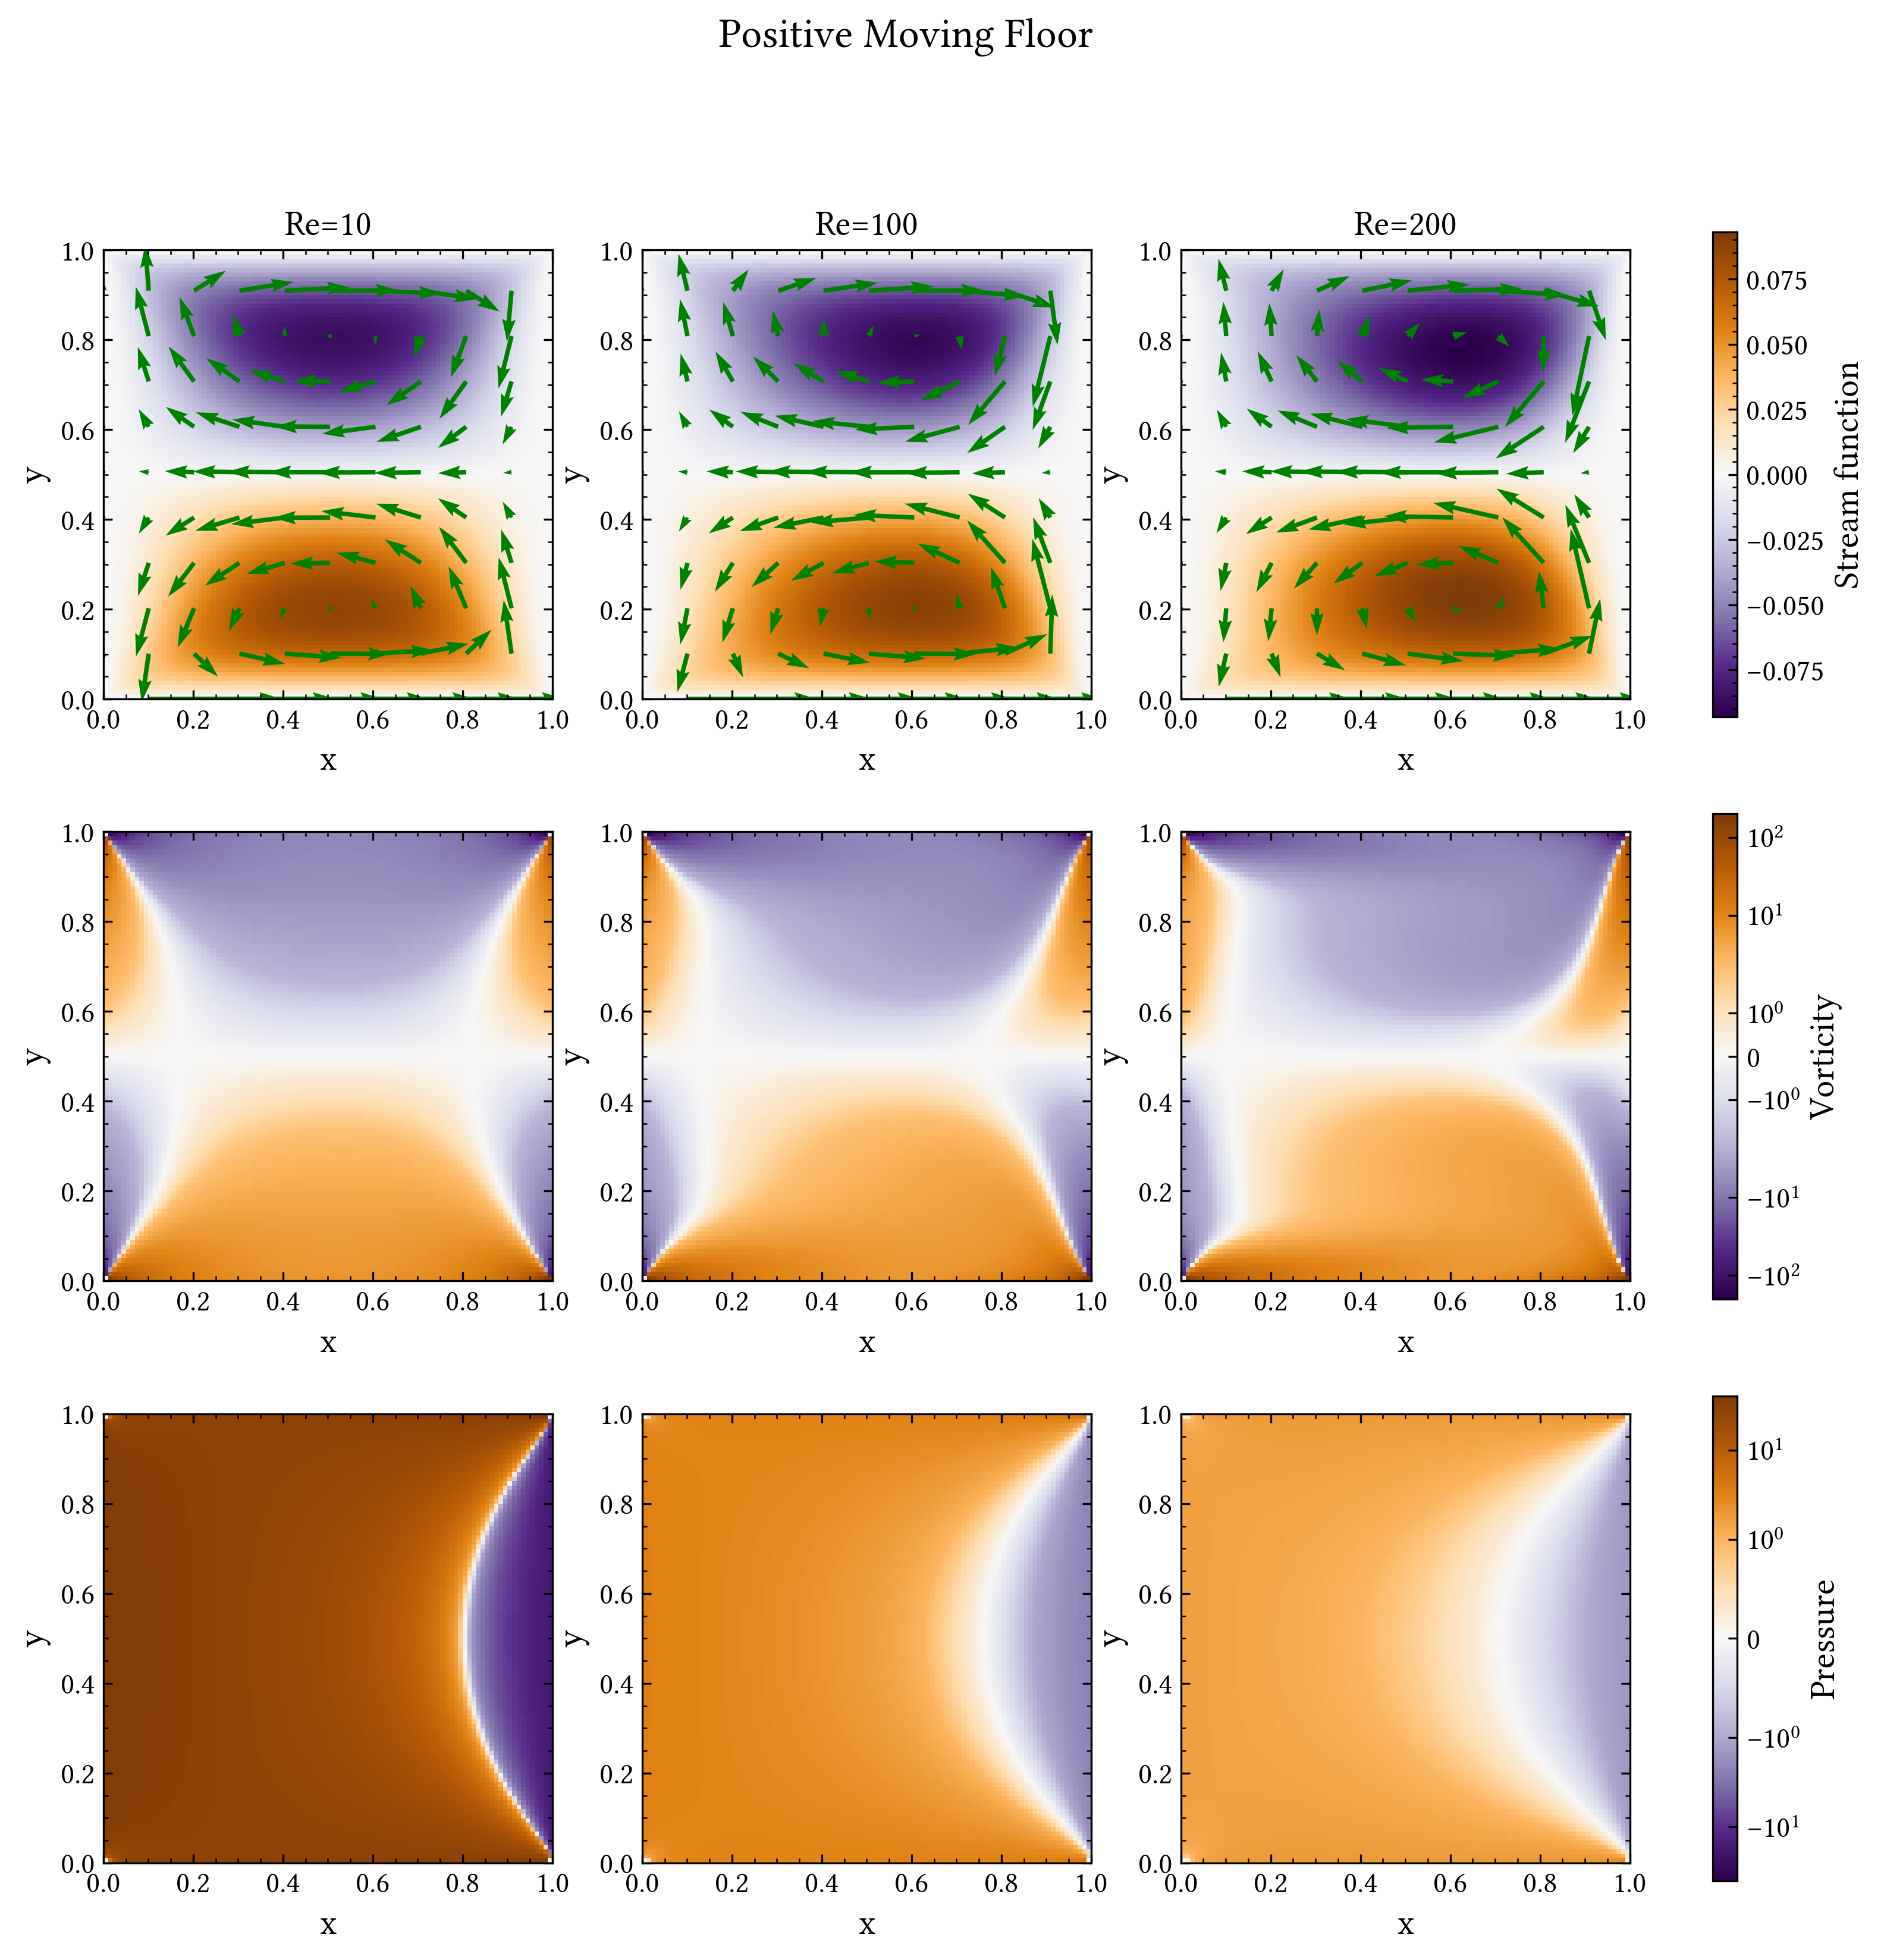

In [37]:
n_vectors = 10 # Number of velocity arrows per row

# ********
# To get a shared color scale, we need to find the min/max values for each row
u_vals = np.concatenate((u_bwp_10.ravel(), u_bwp_100.ravel(), u_bwp_200.ravel())) # np.ravel makes an array 1D
w_vals   = np.concatenate((w_bwp_10.ravel(), w_bwp_100.ravel(), w_bwp_200.ravel()))
p_vals   = np.concatenate((p_bwp_10.ravel(), p_bwp_100.ravel(), p_bwp_200.ravel()))

u_min, u_max = u_vals.min(), u_vals.max()
w_abs = np.abs(w_vals.max()) # The voricity and pressure color scale will be centered around zero 
p_abs = np.abs(p_vals.max())
# w_min,   w_max   = w_vals.min(),   w_vals.max()
# p_min,   p_max   = p_vals.min(),   p_vals.max()

# To have less code, we will plot inside a loop through the Re values
Re_list = [10, 100, 200]
u_dict = {10: u_bwp_10, 100: u_bwp_100, 200: u_bwp_200}
w_dict = {10: w_bwp_10, 100: w_bwp_100, 200: w_bwp_200}
p_dict = {10: p_bwp_10, 100: p_bwp_100, 200: p_bwp_200}

vx_10, vy_10, X, Y = get_velocities(u_bwp_10, h)
vx_100, vy_100, _, _ = get_velocities(u_bwp_100, h)
vx_200, vy_200, _, _ = get_velocities(u_bwp_200, h)
step = int(vx_10.shape[0] / n_vectors)

vx_dict = {10: vx_10, 100: vx_100, 200: vx_200}
vy_dict = {10: vy_10, 100: vy_100, 200: vy_200}

fig, axes = plt.subplots(3, 3, figsize=(12,12))
if print_titles: fig.suptitle("Positive Moving Floor")


for col, Re in enumerate(Re_list):

    # Stream function row
    ax = axes[0, col]
    im0 = ax.imshow(u_dict[Re], origin='lower', extent=[0,1,0,1],
                    cmap='PuOr_r', vmin=u_min, vmax=u_max) # Reversing the colormap so 0 is white
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")
    ax.set_title(f"Re={Re}")

    # Add velocity vectors
    ax.quiver(X[::step, ::step], Y[::step, ::step],
              vx_dict[Re][::step, ::step], vy_dict[Re][::step, ::step], 
              scale=3, width=0.01, color='green')

    # Vorticity row
    ax = axes[1, col]
    # Reversing the colormap because lets be hones, blue feels more like negative. Also using SymLogNorm for better color scale
    im1 = ax.imshow(w_dict[Re], origin='lower', extent=[0,1,0,1],
                    cmap='PuOr_r', norm=SymLogNorm(linthresh=2, linscale=1.0, vmin=-w_abs, vmax=w_abs)) 
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")

    # Pressure row
    ax = axes[2, col]
    im2 = ax.imshow(p_dict[Re], origin='lower', extent=[0,1,0,1],
                    cmap='PuOr_r', norm=SymLogNorm(linthresh=1, linscale=1.0, vmin=-p_abs, vmax=p_abs))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")

# Colorbars for each row, with the same color scale
cbar0 = fig.colorbar(im0, ax=axes[0, :], orientation='vertical', fraction=0.03)
cbar0.set_label("Stream function")

cbar1 = fig.colorbar(im1, ax=axes[1, :], orientation='vertical', fraction=0.03)
cbar1.set_label("Vorticity")

cbar2 = fig.colorbar(im2, ax=axes[2, :], orientation='vertical', fraction=0.03)
cbar2.set_label("Pressure")

plt.savefig('figures/bwp_comparison.pdf')
plt.show()


## **C** Moving Bottom Wall in **Negative** Direction (BWN)

More Copy-Pasting. **SIMULATE** or...

In [40]:
save_data = True

T = 25 # Fix the total amount of time for Re=100 and Re=200. Re=10 is quickly in steady state.
grid_size = (100,100)
h = 1/grid_size[0] # Since side length is 1

SOR_tol = 1e-4
dt_10 = 0.1*h*h*10 # Stability condition, to be on the safe side we take 0.1 instead of 0.25
nt_10 = int(5/dt_10) # We take only 5 seconds here 

dt_100 = 0.1*h*h*100 
nt_100 = int(T/dt_100)

dt_200 = 0.1*h*h*200 
nt_200 = int(T/dt_200)

print(f"Re=10, dt={dt_10:.3e}, nt={nt_10}")
# bwn = positive moving bottom wall
ldc_bwn_10 = LDC(h=h,
             dt = dt_10,
             Re = 10,
             grid_size=grid_size,
             vx_bottom=-1 # Moving bottom wall
             )

u_bwn_10, w_bwn_10, p_bwn_10, vxc_bwn_10 = ldc_bwn_10.system_evolution(n_t=nt_10, get_pressure=True, SOR_tol=SOR_tol)

# Save the data as dictionary so to not run the simulation again
if save_data:
    ldc_bwn_10 = {'u': u_bwn_10, 'w': w_bwn_10, 'vxc': vxc_bwn_10, 'p': p_bwn_10, 'params': (h, dt_10, nt_10)}
    np.save('data/ldc_bwn_10.npy', ldc_bwn_10)

print(f"Re=100, dt={dt_100:.3e}, nt={nt_100}")
ldc_bwn_100 = LDC(h=h,
             dt = dt_100,
             Re = 100,
             grid_size=grid_size,
             vx_bottom=-1 
             )

u_bwn_100, w_bwn_100, p_bwn_100, vxc_bwn_100 = ldc_bwn_100.system_evolution(n_t=nt_100, get_pressure=True, SOR_tol=SOR_tol)

if save_data:
    ldc_bwn_100 = {'u': u_bwn_100, 'w': w_bwn_100, 'vxc': vxc_bwn_100, 'p': p_bwn_100, 'params': (h, dt_100, nt_100)}
    np.save('data/ldc_bwn_100.npy', ldc_bwn_100)

print(f"Re=200, dt={dt_200:.3e}, nt={nt_200}")
ldc_bwn_200 = LDC(h = h,
             dt = dt_200,
             Re = 200,
             grid_size=grid_size,
             vx_bottom=-1
             )

u_bwn_200, w_bwn_200, p_bwn_200, vxc_bwn_200  = ldc_bwn_200.system_evolution(n_t=nt_200, get_pressure=True, SOR_tol=SOR_tol)

if save_data:
    ldc_bwn_200 = {'u': u_bwn_200, 'w': w_bwn_200, 'vxc': vxc_bwn_200, 'p': p_bwn_200, 'params': (h, dt_200, nt_200)}
    np.save('data/ldc_bwn_200.npy', ldc_bwn_200)

Re=10, dt=1.000e-04, nt=50000
Stability criterion value: 0.100


100%|██████████| 49999/49999 [13:01<00:00, 64.00it/s]


Re=100, dt=1.000e-03, nt=25000
Stability criterion value: 0.100


100%|██████████| 24999/24999 [06:34<00:00, 63.39it/s]


Re=200, dt=2.000e-03, nt=12500
Stability criterion value: 0.100


100%|██████████| 12499/12499 [03:20<00:00, 62.48it/s]


... **LOAD**

In [29]:
ldc_bwn_10 = np.load('data/ldc_bwn_10.npy', allow_pickle=True).item()
u_bwn_10 = ldc_bwn_10['u']
w_bwn_10 = ldc_bwn_10['w']
vxc_bwn_10 = ldc_bwn_10['vxc']
p_bwn_10 = ldc_bwn_10['p']
h, dt_10, nt_10 = ldc_bwn_10['params']

ldc_bwn_100 = np.load('data/ldc_bwn_100.npy', allow_pickle=True).item()
u_bwn_100 = ldc_bwn_100['u']
w_bwn_100 = ldc_bwn_100['w']
vxc_bwn_100 = ldc_bwn_100['vxc'] 
p_bwn_100 = ldc_bwn_100['p']
_, dt_100, nt_100 = ldc_bwn_100['params']

ldc_bwn_200 = np.load('data/ldc_bwn_200.npy', allow_pickle=True).item()
u_bwn_200 = ldc_bwn_200['u'] 
w_bwn_200 = ldc_bwn_200['w']
vxc_bwn_200 = ldc_bwn_200['vxc']
p_bwn_200 = ldc_bwn_200['p']
_, dt_200, nt_200 = ldc_bwn_200['params']

In [ ]:
t_10 = np.arange(nt_10)*dt_10
t_100 = np.arange(nt_100)*dt_100
t_200 = np.arange(nt_200)*dt_200

fig, ax = plt.subplots(figsize=fsize_small)
if print_titles: fig.suptitle(r"Central $v_x$ with Negative Moving Floor")

ax.plot(t_10[1:], vxc_bwn_10[1:], label='Re=10')
ax.plot(t_100[1:], vxc_bwn_100[1:], label='Re=100', linestyle='--')
ax.plot(t_200[1:], vxc_bwn_200[1:], label='Re=200', linestyle=':')

ax.set_xlabel(r"t")
ax.set_ylabel(r"$v_x$ at center")
ax.legend()

plt.savefig('figures/vxc_bwn.pdf')
plt.show()

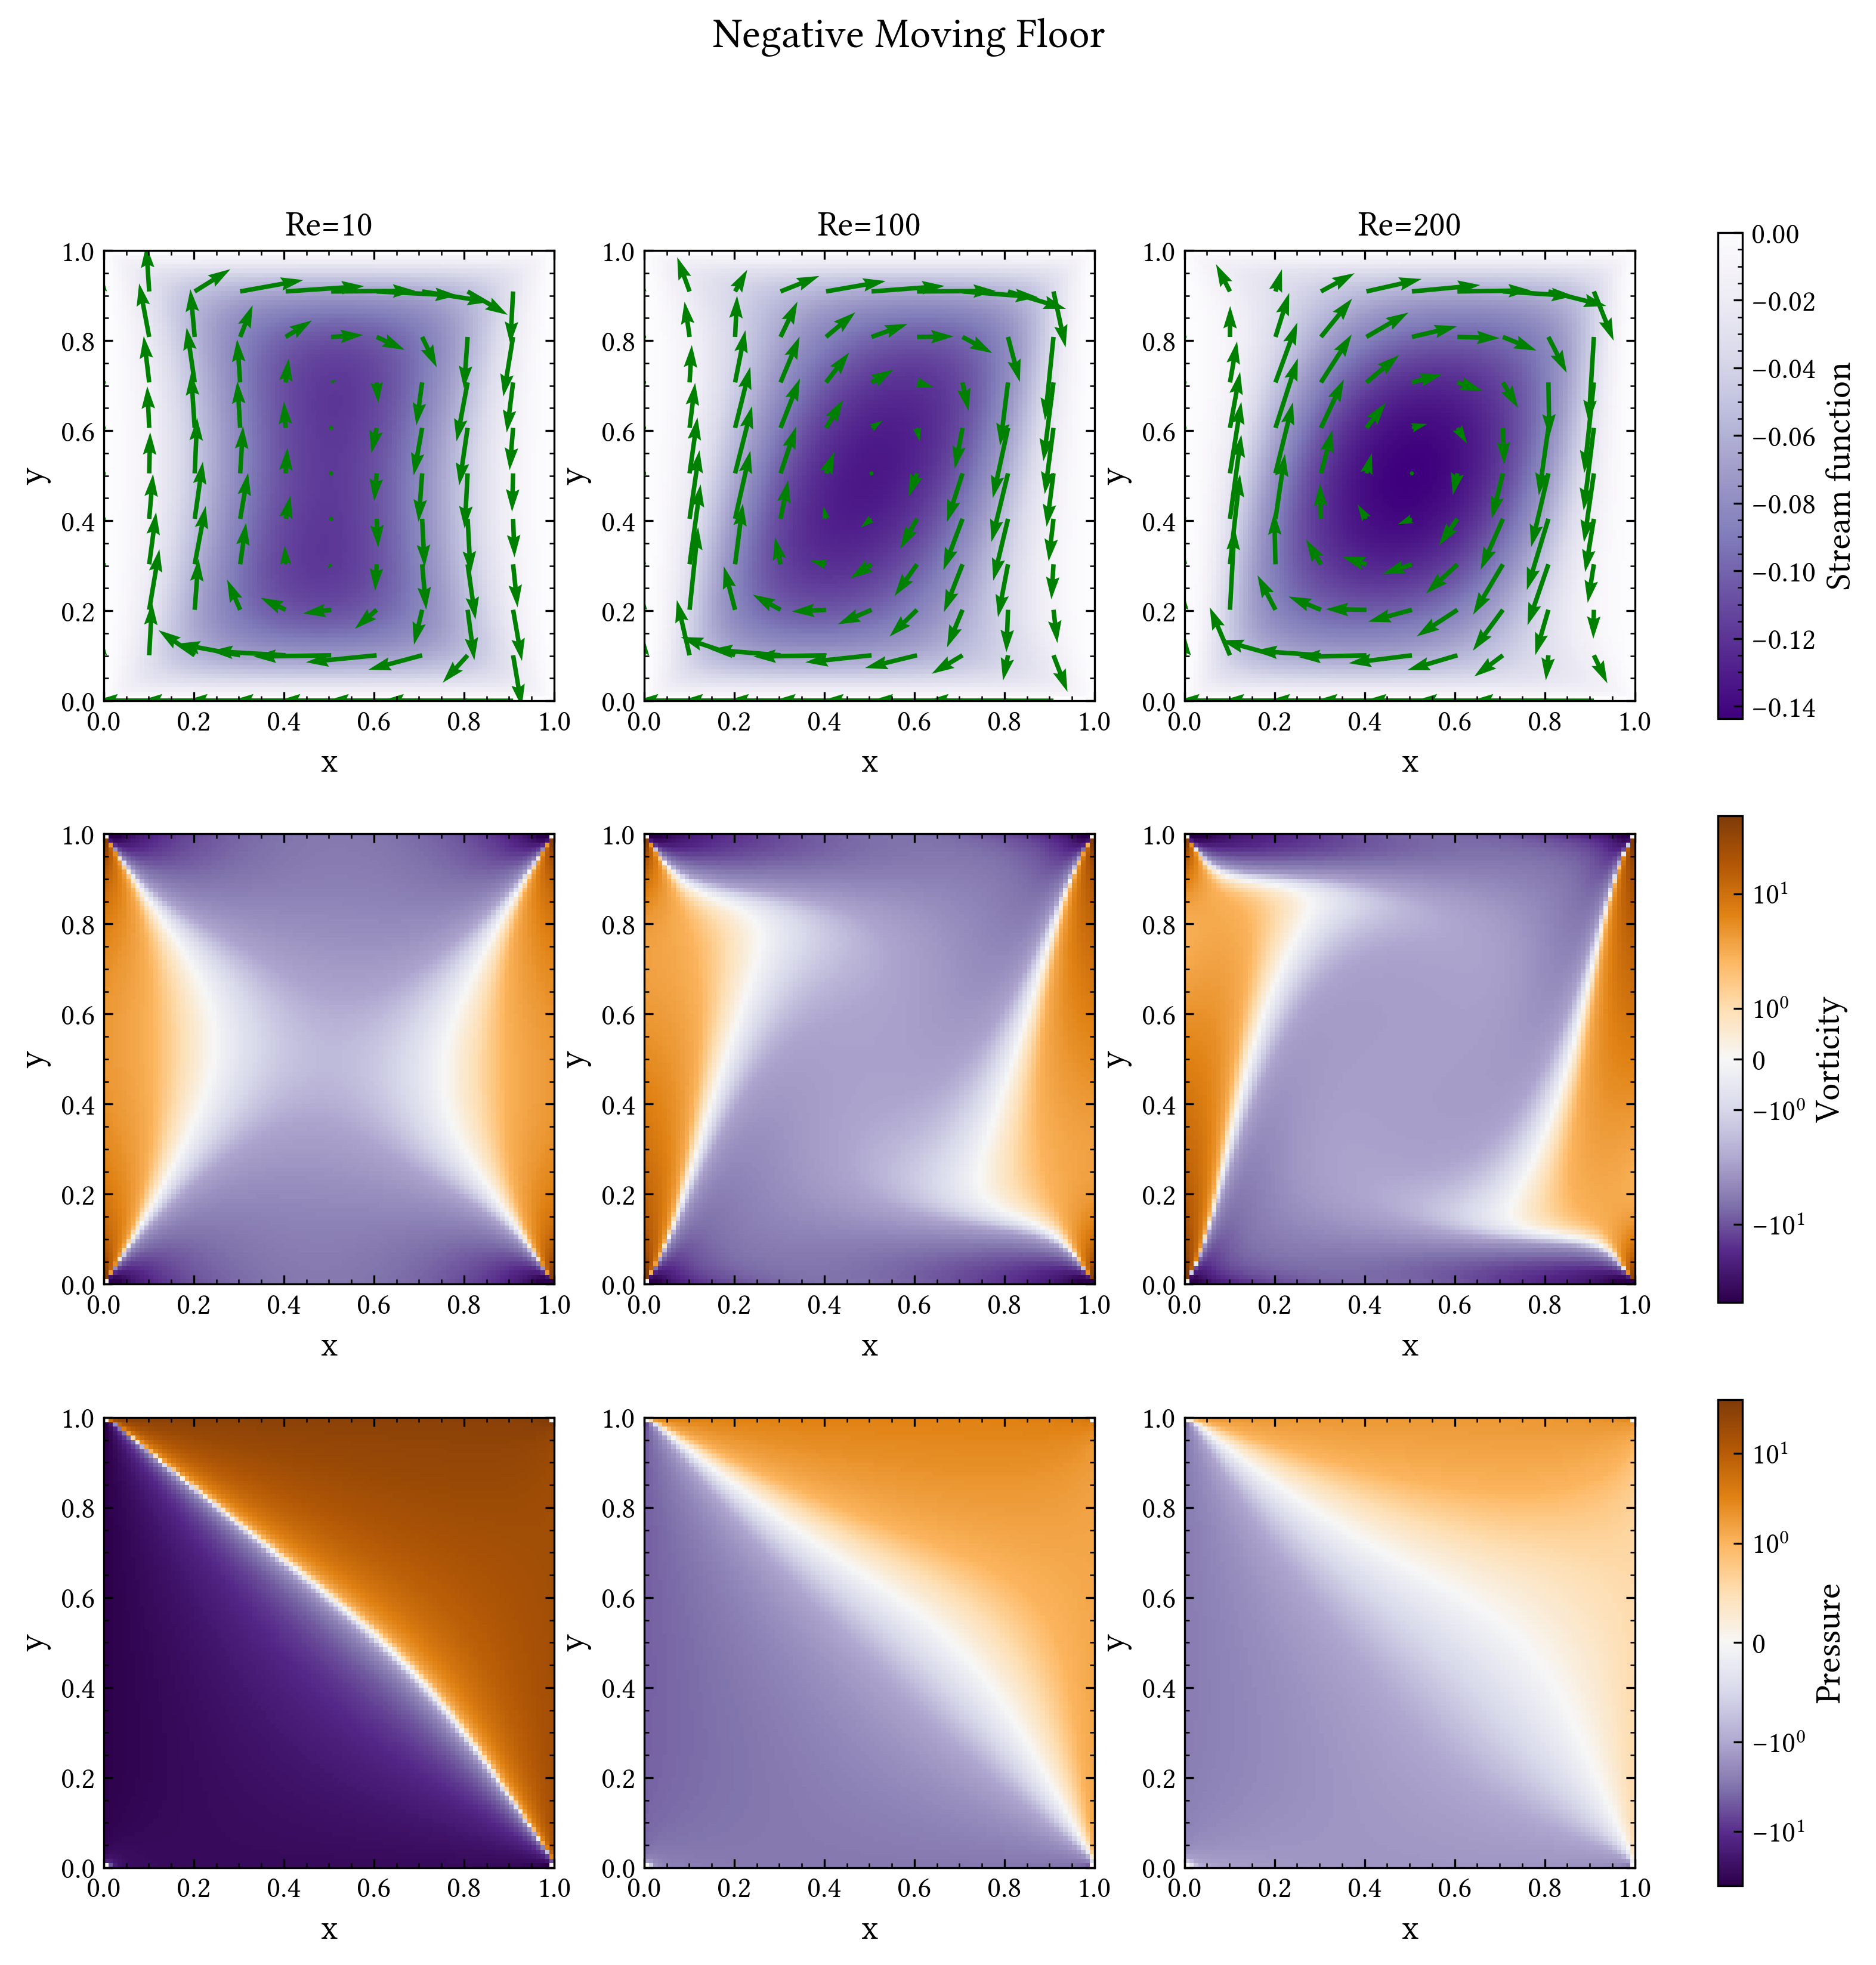

In [41]:
# To get a shared color scale, we need to find the min/max values for each row
u_vals = np.concatenate((u_bwn_10.ravel(), u_bwn_100.ravel(), u_bwn_200.ravel())) # np.ravel makes an array 1D
w_vals   = np.concatenate((w_bwn_10.ravel(), w_bwn_100.ravel(), w_bwn_200.ravel()))
p_vals   = np.concatenate((p_bwn_10.ravel(), p_bwn_100.ravel(), p_bwn_200.ravel()))

u_min, u_max = u_vals.min(), u_vals.max()
w_abs = np.abs(w_vals.max()) # The voricity and pressure color scale will be centered around zero 
p_abs = np.abs(p_vals.max())

# To have less code, we will plot inside a loop through the Re values
Re_list = [10, 100, 200]
u_dict = {10: u_bwn_10, 100: u_bwn_100, 200: u_bwn_200}
w_dict = {10: w_bwn_10, 100: w_bwn_100, 200: w_bwn_200}
p_dict = {10: p_bwn_10, 100: p_bwn_100, 200: p_bwn_200}

vx_10, vy_10, X, Y = get_velocities(u_bwn_10, h)
vx_100, vy_100, _, _ = get_velocities(u_bwn_100, h)
vx_200, vy_200, _, _ = get_velocities(u_bwn_200, h)
step = int(vx_10.shape[0] / n_vectors)

vx_dict = {10: vx_10, 100: vx_100, 200: vx_200}
vy_dict = {10: vy_10, 100: vy_100, 200: vy_200}

fig, axes = plt.subplots(3, 3, figsize=(12,12))
if print_titles: fig.suptitle("Negative Moving Floor")

for col, Re in enumerate(Re_list):

    # Stream function row
    ax = axes[0, col]
    im0 = ax.imshow(u_dict[Re], origin='lower', extent=[0,1,0,1],
                    cmap='Purples_r', vmin=u_min, vmax=u_max) # Reversing the colormap so 0 is white
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")
    ax.set_title(f"Re={Re}")

    ax.quiver(X[::step, ::step], Y[::step, ::step],
              vx_dict[Re][::step, ::step], vy_dict[Re][::step, ::step], 
              scale=3, width=0.01, color='green')
    

    # Vorticity row
    ax = axes[1, col]
    # Reversing the colormap because lets be hones, blue feels more like negative. Also using SymLogNorm for better color scale
    im1 = ax.imshow(w_dict[Re], origin='lower', extent=[0,1,0,1],
                    cmap='PuOr_r', norm=SymLogNorm(linthresh=2, linscale=1.0, vmin=-w_abs, vmax=w_abs)) 
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")

    # Pressure row
    ax = axes[2, col]
    im2 = ax.imshow(p_dict[Re], origin='lower', extent=[0,1,0,1],
                    cmap='PuOr_r', norm=SymLogNorm(linthresh=1, linscale=1.0, vmin=-p_abs, vmax=p_abs))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")

# Colorbars for each row, with the same color scale
cbar0 = fig.colorbar(im0, ax=axes[0, :], orientation='vertical', fraction=0.03)
cbar0.set_label("Stream function")

cbar1 = fig.colorbar(im1, ax=axes[1, :], orientation='vertical', fraction=0.03)
cbar1.set_label("Vorticity")

cbar2 = fig.colorbar(im2, ax=axes[2, :], orientation='vertical', fraction=0.03)
cbar2.set_label("Pressure")

plt.savefig('figures/bwn_comparison.pdf')
plt.show()


# Additional Code

When running the first simulation with a lower grid size like 20x20, we get a different result for the horizontal velocity:

In [ ]:
T = 25 # Fix the total amount of time for every Re
grid_size = (20,20)
h = 1/grid_size[0] # Since side length is 1

SOR_tol = 1e-4
dt_10 = 0.1*h*h*10 # Stability condition, to be on the safe side we take 0.1 instead of 0.25
nt_10 = int(T/dt_10) # To get the same total time

dt_100 = 0.1*h*h*100 
nt_100 = int(T/dt_100)

dt_200 = 0.1*h*h*200 
nt_200 = int(T/dt_200)

print("Re=10")
ldc_10 = LDC(h=h,
             dt = dt_10,
             Re = 10,
             grid_size=grid_size,
             )

_, _, _, vxc_10_small = ldc_10.system_evolution(n_t=nt_10, get_pressure=True, SOR_tol=SOR_tol)


print("Re=100")
ldc_100 = LDC(h=h,
             dt = dt_100,
             Re = 100,
             grid_size=grid_size,
             )

_, _, _, vxc_100_small = ldc_100.system_evolution(n_t=nt_100, get_pressure=True, SOR_tol=SOR_tol)


print("Re=200")
ldc_200 = LDC(h = h,
             dt = dt_200,
             Re = 200,
             grid_size=grid_size,
             )

_, _, _, vxc_200_small  = ldc_200.system_evolution(n_t=nt_200, get_pressure=True, SOR_tol=SOR_tol)


In [ ]:
t_10 = np.arange(nt_10)*dt_10
t_100 = np.arange(nt_100)*dt_100
t_200 = np.arange(nt_200)*dt_200

fig, ax = plt.subplots(figsize=fsize_small)
fig.suptitle("Horizontal Velocity at the Center of the Cavity")

ax.plot(t_10[1:], vxc_10_small[1:], label='Re=10')
ax.plot(t_100[1:], vxc_100_small[1:], label='Re=100', linestyle='--')
ax.plot(t_200[1:], vxc_200_small[1:], label='Re=200', linestyle=':')

ax.set_xlabel(r"t")
ax.set_ylabel(r"$v_x$ at center")
ax.legend()

plt.savefig('figures/vx_center_smallgrid.pdf')
plt.show()

# Dump

Old `update_vorticity` that uses python loop calculations instead of more efficient numpy arrays:

In [ ]:

# def update_vorticity(self,u, w):

#     w_new = np.copy(w)

#     for j in range(1, self.N_y-1):
#         for i in range(1, self.N_x-1):
#             term1a = (u[j,i+1] - u[j,i-1]) * (w[j+1,i] - w[j-1,i]) 
#             term1b = (u[j+1,i] - u[j-1,i]) * (w[j,i+1] - w[j,i-1])
#             term2 = w[j,i+1] + w[j,i-1] + w[j+1,i] + w[j-1,i] - 4*w[j,i]

#             w_new[j,i] = w[j,i] + self.dt/(self.h*self.h) * (0.25 * (term1a - term1b) + (1/self.Re) * (term2))
    
#     return w_new 

The pressure function but as a normal part of the class. Had to be adjusted for Numba.

In [ ]:


    # def update_pressure_SOR(self, p, u, omega, max_iter, tol):
    #     ''' 
    #       This is the old pressure update function, that is way more inefficient.
    #     '''
        
    #     for it in range(max_iter):
    #         max_r = 0.0
    #         for j in range(1, self.N_y-1):
    #             for i in range(1, self.N_x-1):
    #                 termA = (p[j,i+1] + p[j,i-1] + p[j+1,i] + p[j-1,i])
    #                 termB = 2 * (u[j,i+1] + u[j,i-1] + u[j+1,i] + u[j-1,i] - 4*u[j,i]) 
    #                 termC = 1/(8*self.h**2) * (u[j+1,i+1] - u[j-1,i+1] - u[j+1,i-1] + u[j-1,i-1])**2
    #                 p_new = (0.25) * (termA - termB - termC)

    #                 r = p_new - p[j,i]
    #                 p[j,i] += omega * r
    #                 max_r = max(max_r, abs(r))

    #         if max_r < tol: break

    #     return p
    